In [7]:
#
# FULL ENHANCED HTPC + HTM MODEL
#  Includes L3, plotting, sparse L1 visualization
#
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


# === Minicolumn Encoder ===
class MinicolumnEncoder(nn.Module):
    def __init__(self, n_columns, cells_per_column):
        super().__init__()
        self.n_columns = n_columns
        self.cells_per_column = cells_per_column
        self.total_cells = n_columns * cells_per_column
        self.recurrent_weights = nn.Parameter(torch.zeros(self.total_cells, self.total_cells))

    def activate(self, input_vector, prev_state):
        input_cells = input_vector.repeat_interleave(self.cells_per_column)
        context_input = torch.matmul(self.recurrent_weights, prev_state)
        combined = input_cells + context_input
        combined = combined.view(self.n_columns, self.cells_per_column)
        active_cells = torch.zeros_like(combined)
        #winners = torch.argmax(combined, dim=1)
        noise = 0.01 * torch.rand_like(combined)  # small randomness
        combined += noise
        winners = torch.argmax(combined, dim=1)
        self.last_winners = winners.detach().clone()
        active_cells[range(self.n_columns), winners] = 1.0
        return active_cells.view(-1)

    def learn(self, prev_state, current_state, lr=0.01):
        dw = torch.ger(current_state, prev_state)
        self.recurrent_weights.data += lr * dw

# === HTPC Layer ===
class HTPCLayer(nn.Module):
    def __init__(self, size, next_size=None, prev_size=None):
        super().__init__()
        self.size = size
        self.state = torch.zeros(size)
        self.prediction = torch.zeros(size)
        self.error = torch.zeros(size)
        self.ff_weights = nn.Parameter(torch.randn(size, prev_size) * 0.1) if prev_size else None
        self.fb_weights = nn.Parameter(torch.randn(size, next_size) * 0.1) if next_size else None

    def forward(self, bottom_up=None, top_down=None):
        ff_input = F.linear(bottom_up, self.ff_weights) if self.ff_weights is not None and bottom_up is not None else 0
        fb_input = F.linear(top_down, self.fb_weights) if self.fb_weights is not None and top_down is not None else 0
        #self.state = torch.tanh(ff_input + fb_input)
        self.state = torch.relu(ff_input + fb_input)  # OR
        #self.state = ff_input + fb_input  # Raw linear
        self.prediction = fb_input
        self.error = self.state - self.prediction
        return self.state, self.error

# === Full HTPC-HTM Model with L3 and visualization ===
class HTPCModelHTM(nn.Module):
    def __init__(self, n_columns=10, cells_per_column=16, l2_size=10, l3_size=5):
        super().__init__()
        self.encoder = MinicolumnEncoder(n_columns, cells_per_column)
        self.n_input = n_columns * cells_per_column
        self.L2 = HTPCLayer(l2_size, prev_size=self.n_input, next_size=l3_size)
        self.L3 = HTPCLayer(l3_size, prev_size=l2_size)
        self.L1_fb = nn.Parameter(torch.randn(self.n_input, l2_size) * 0.1)

        self.prev_L1_state = torch.zeros(self.n_input)
        self.current_input_column = torch.zeros(n_columns)

        # Logs
        self.log_L1_acts = []
        self.log_L1_error = []
        self.log_L2_error = []

    def forward(self, column_input):
        self.current_input_column = column_input.clone()

        # L1 Activation
        L1_state = self.encoder.activate(column_input, self.prev_L1_state)

        # Feedforward
        L2_state, _ = self.L2.forward(bottom_up=L1_state)
        L3_state, _ = self.L3.forward(bottom_up=self.L2.state)

        # Feedback
        self.L2.forward(top_down=L3_state)
        #L1_pred = F.linear(self.L2.state, self.L1_fb)
        self.L1_pred_bias = nn.Parameter(torch.zeros(self.n_input))
        L1_pred = F.linear(self.L2.state, self.L1_fb) + self.L1_pred_bias
        L1_error = L1_state - L1_pred

        # Logs
        self.log_L1_acts.append(L1_state.detach().numpy())
        self.log_L1_error.append(torch.sum(L1_error ** 2).item())
        self.log_L2_error.append(torch.sum(self.L2.error ** 2).item())

        self.prev_L1_state = L1_state.clone()
        #print("FF dW (L2):", torch.norm(torch.ger(self.L2.error, self.prev_L1_state)).item())
        #print("FB dW (L1):", torch.norm(torch.ger(-self.prev_L1_state, self.L2.state)).item())
        return {"L1_error": L1_error}

    def learn(self, lr=0.01):
        with torch.no_grad():
            pred = F.linear(self.L2.state, self.L1_fb)
            error = self.prev_L1_state - pred
            self.L1_fb += lr * torch.ger(error, self.L2.state)

            self.L2.ff_weights += lr * torch.ger(self.L2.error, self.prev_L1_state)
            self.L3.ff_weights += lr * torch.ger(self.L3.error, self.L2.state)

            new_L1_state = self.encoder.activate(self.current_input_column, self.prev_L1_state)
            self.encoder.learn(self.prev_L1_state, new_L1_state, lr=lr)


    def reset_logs(self):
        self.log_L1_acts.clear()
        self.log_L1_error.clear()
        self.log_L2_error.clear()

    def plot_results(self):
        fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

        axs[0].imshow(np.array(self.log_L1_acts).T, aspect='auto', cmap='Greys')
        axs[0].set_title("L1 Sparse Activations (minicolumn cells)")
        axs[0].set_ylabel("Cell index")

        axs[1].plot(self.log_L1_error, label='L1 Error', color='magenta')
        axs[1].set_title("L1 Prediction Error")
        axs[1].set_ylabel("MSE")

        axs[2].plot(self.log_L2_error, label='L2 Error', color='orange')
        axs[2].set_title("L2 Prediction Error")
        axs[2].set_ylabel("MSE")
        axs[2].set_xlabel("Time step")

        plt.tight_layout()
        plt.show()



Testing A → B → C
Winning cells per column at t= tensor([ 5,  6,  8,  2,  7, 12, 14,  8, 14,  2])
Winning cells per column at t= tensor([ 1,  1, 13,  5, 13,  6,  5,  1,  9, 10])
Winning cells per column at t= tensor([ 5,  6,  8,  2,  7, 12, 14,  8, 14,  2])


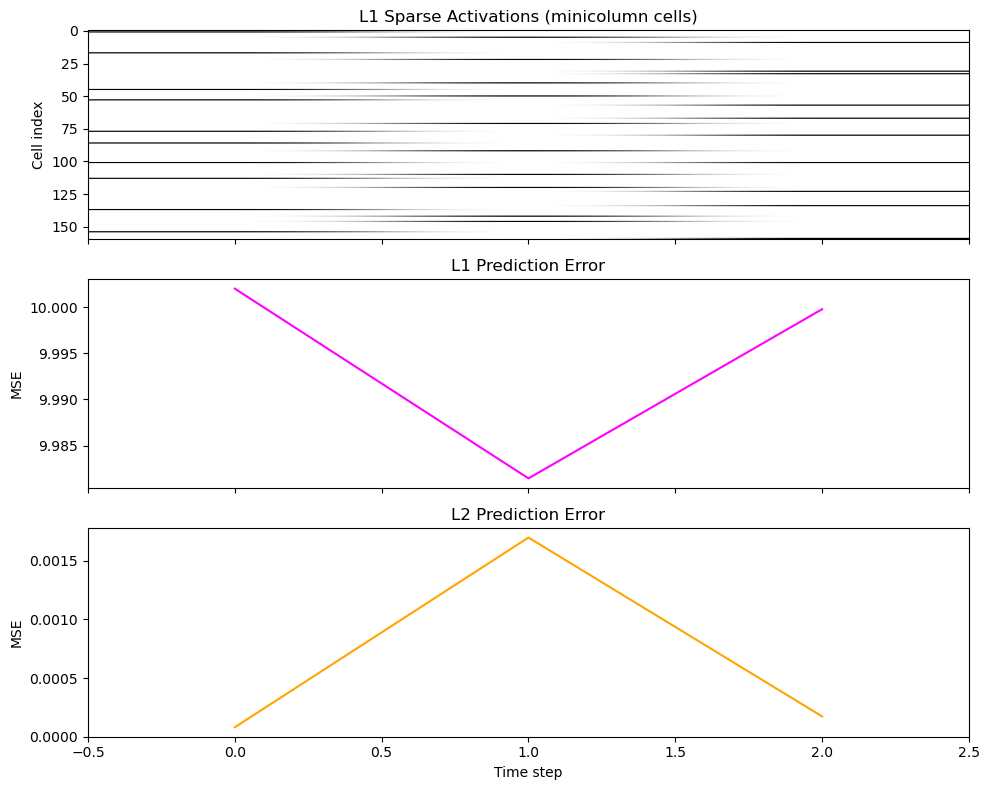

In [9]:
# Setup
n_columns = 10
cells_per_column = 16
model = HTPCModelHTM(n_columns=n_columns, cells_per_column=cells_per_column)

# Build overlapping sequences
def make_column_input(indices):
    vec = torch.zeros(n_columns)
    vec[indices] = 1.0
    return vec

# === SEQUENCES ===
A = make_column_input([0])
B = make_column_input([1])
C = make_column_input([2])
X = make_column_input([3])
Y = make_column_input([4])

seq1 = [A, B, C]  # Sequence 1
seq2 = [A, X, Y]  # Sequence 2

# === TRAINING ===
model.reset_logs()

for epoch in range(30):
    #print(f"Epoch {epoch+1}")

    for seq in [seq1, seq2]:
        model.prev_L1_state = torch.zeros_like(model.prev_L1_state)

        # STEP 1: Feed A
        model.forward(seq[0])  # A input
        A_L2_state = model.L2.state.clone()

        # === ✨ PRIMING: Teach model what should come after A ===
        if epoch < 5:
            target = seq[1]  # B or X
            expected_L1 = model.encoder.activate(target, model.prev_L1_state)

            with torch.no_grad():
                # Either zero weights and set only these, or reinforce existing ones
                model.L1_fb.data[expected_L1.bool(), :] = A_L2_state

        # STEP 2: Feed next (B or X)
        model.forward(seq[1])
        model.learn(lr=0.01)

        # STEP 3: Feed final (C or Y)
        model.forward(seq[2])
        model.learn(lr=0.01)


# === TESTING ===
model.reset_logs()
model.prev_L1_state = torch.zeros_like(model.prev_L1_state)
print("\nTesting A → B → C")
for step in [A, B, C]:
    print("Winning cells per column at t=", model.encoder.last_winners)
    model.forward(step)

#model.prev_L1_state = torch.zeros_like(model.prev_L1_state)
#print("\nTesting A → X → Y")
#for step in [A, X, Y]:
#    model.forward(step)

model.plot_results()

